# **NYC Spatiotemporal Crash Analysis & Alarm System**

Imagine you're responsible for school bus safety in NYC. You have thousands of crash reports,
but they're just numbers in a spreadsheet. This system is like having a smart detective that:

1. Reads all the crash reports automatically
2. Finds patterns of where crashes are clustering (hotspots)
3. Identifies if dangerous areas are getting worse over time
4. Gives you specific recommendations
5. Creates easy-to-read maps and charts showing the most dangerous areas

Instead of waiting for accidents to happen, you can prevent them by focusing resources on the right places at the right time.

### **Step 1: Installing required tools**

In [ ]:
!pip install h3 folium plotly pymannkendall esda libpysal geopandas -q

### **Step 2: Import all necessary libraries**

In [ ]:
import pandas as pd
import numpy as np
import h3
import folium
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pymannkendall as mk
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("All libraries loaded successfully!")

All libraries loaded successfully!


Think of this like getting all the right tools before starting a complex project.
We need different "toolboxes" for different tasks:

- h3: Divides maps into hexagon shapes (like cutting a pizza into equal slices)
- folium: Creates interactive maps you can click and zoom
- plotly: Makes charts and graphs that show trends over time
- pymannkendall: Does statistical tests to see if things are getting better/worse
- esda: Finds "hotspots" using advanced spatial statistics

Without these tools, it's like trying to build a house without a hammer or saw.
Each tool has a specific job that makes the analysis possible.

### **Step 3: Loading NYC Motor Vehicle Crash data**

In [ ]:
df = pd.read_csv('/content/Motor_Vehicle_Collisions_-_Crashes_20250817.csv')

print(f"Dataset loaded with {len(df):,} crash records")
print(f"Data columns available: {list(df.columns)}")
df.head()

Dataset loaded with 2,198,310 crash records
Data columns available: ['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5', 'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5']


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,03/26/2022,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,11/01/2023,1:29,BROOKLYN,11230.0,40.62179,-73.970024,"(40.62179, -73.970024)",OCEAN PARKWAY,AVENUE K,NaN,...,Unspecified,Unspecified,NaN,NaN,4675373,Moped,Sedan,Sedan,NaN,NaN
3,06/29/2022,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
4,09/21/2022,13:21,NaN,NaN,NaN,NaN,NaN,BROOKLYN BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4566131,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN


In [ ]:
# Check the coordinate data quality
print(f"\n Coordinate data quality check:")
print(f"• Total LATITUDE values: {df['LATITUDE'].notna().sum():,}")
print(f"• Total LONGITUDE values: {df['LONGITUDE'].notna().sum():,}")
print(f"• LATITUDE range: {df['LATITUDE'].min()} to {df['LATITUDE'].max()}")
print(f"• LONGITUDE range: {df['LONGITUDE'].min()} to {df['LONGITUDE'].max()}")

# Show sample coordinates
print(f"\n Sample valid coordinates:")
valid_coords = df[['LATITUDE', 'LONGITUDE']].dropna()
valid_coords.head(10)


 Coordinate data quality check:
• Total LATITUDE values: 1,958,141
• Total LONGITUDE values: 1,958,141
• LATITUDE range: 0.0 to 43.344444
• LONGITUDE range: -201.35999 to 0.0

 Sample valid coordinates:


,LATITUDE,LONGITUDE
2,40.621790,-73.970024
9,40.667202,-73.866500
10,40.683304,-73.917274
12,40.709183,-73.956825
13,40.868160,-73.831480
14,40.671720,-73.897100
15,40.751440,-73.973970
16,40.701275,-73.888870
17,40.675884,-73.755770
19,40.596620,-74.002310


This is like opening a huge filing cabinet full of traffic accident reports.
Each row in our data represents one real crash that happened in NYC.

What each crash record contains:
- When it happened (date and time)
- Where it happened (street address, latitude/longitude)
- How many people were injured or killed
- What types of vehicles were involved
- What caused the crash (if known)

This raw data is the foundation of everything we do. If we had bad data
(wrong locations, missing dates), our analysis would give wrong answers.
It's like trying to navigate with a broken GPS.

### **Step 4: Cleaning and Preparing The Data**

In [ ]:
# Convert crash date to datetime format
# Use errors='coerce' to turn invalid date formats into NaT (Not a Time)
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'], errors='coerce')
# Convert crash time to datetime format
df['CRASH TIME'] = pd.to_datetime(df['CRASH TIME'], errors='coerce')

In [ ]:
# Check data before cleaning
print(f"Before cleaning: {len(df):,} total records")
print(f"Records with valid LATITUDE: {df['LATITUDE'].notna().sum():,}")
print(f"Records with valid LONGITUDE: {df['LONGITUDE'].notna().sum():,}")

Before cleaning: 2,198,310 total records
Records with valid LATITUDE: 1,958,141
Records with valid LONGITUDE: 1,958,141


In [ ]:
# Remove rows without location data
df_clean = df.dropna(subset=['LATITUDE', 'LONGITUDE']).copy()
print(f"After removing records without coordinates: {len(df_clean):,}")

After removing records without coordinates: 1,958,141


In [ ]:
# Check if coordinates are in valid NYC range
valid_nyc_lat = (df_clean['LATITUDE'] >= 40.4) & (df_clean['LATITUDE'] <= 40.9)
valid_nyc_lon = (df_clean['LONGITUDE'] >= -74.3) & (df_clean['LONGITUDE'] <= -73.7)
valid_nyc_coords = valid_nyc_lat & valid_nyc_lon

print(f"Records with NYC area coordinates: {valid_nyc_coords.sum():,}")
df_clean = df_clean[valid_nyc_coords].copy()

Records with NYC area coordinates: 1,946,774


In [ ]:
# Filter for recent 2 months of data
max_date = df_clean['CRASH DATE'].max()
min_date = max_date - timedelta(days=60)
df_recent = df_clean[df_clean['CRASH DATE'] >= min_date].copy()

print(f"After cleaning: {len(df_recent):,} crashes with valid locations")
print(f"Date range: {min_date.strftime('%m-%d-%Y')} to {max_date.strftime('%m-%d-%Y')}")

if len(df_recent) == 0:
    print("No valid data remaining after cleaning!")
    print("Let's check what went wrong...")
    print(f"Original data range: {df['CRASH DATE'].min()} to {df['CRASH DATE'].max()}")
    print(f"Coordinate ranges: LAT {df['LATITUDE'].min()}-{df['LATITUDE'].max()}, LON {df['LONGITUDE'].min()}-{df['LONGITUDE'].max()}")
else:
    print(f"Ready to proceed with {len(df_recent):,} valid crash records")

After cleaning: 13,649 crashes with valid locations
Date range: 06-13-2025 to 08-12-2025
Ready to proceed with 13,649 valid crash records


This is like sorting through those crash reports and organizing them properly.
We need to throw out incomplete or unusable reports, just like you'd throw out
a torn or unreadable document.

What gets removed:
1. Crashes without location data (can't analyze what we can't locate)
2. Crashes outside NYC boundaries (wrong city data got mixed in)
3. Very old crashes (we focus on recent patterns for current decision-making)

We look at the most recent 2 months of data because:
- Recent patterns are more relevant for current safety decisions
- Too much old data can hide recent changes
- Keeps the analysis running fast

Bad data = bad decisions. If we included crashes from the wrong city,
we'd be telling you to patrol streets that don't exist in NYC!
Clean data ensures accurate, actionable recommendations. You might start with 100,000 crashes but end up with 15,000-20,000 recent crashes with good location data. This is normal and expected.

### **Step 5: Creating Spatial Bins Using H3 HEXAGONS**

In [ ]:
# Only proceed if we have valid data
if 'df_recent' in locals() and len(df_recent) > 0:
    # Resolution 9 creates hexagons about 174m across (good for city analysis)
    H3_RESOLUTION = 9

    def lat_lon_to_h3(row):
        """Convert latitude/longitude to H3 hexagon ID"""
        try:
            lat = row['LATITUDE']
            lon = row['LONGITUDE']
            if pd.isna(lat) or pd.isna(lon):
                return None

            # Try the newer H3 API first, then fall back to older API
            try:
                return h3.latlng_to_cell(lat, lon, H3_RESOLUTION)
            except AttributeError:
                # Fallback for older h3 versions
                return h3.geo_to_h3(lat, lon, H3_RESOLUTION)

        except Exception as e:
            print(f"H3 conversion error for lat={lat}, lon={lon}: {e}")
            return None

    # Test H3 conversion on a few samples first
    print("Testing H3 conversion on sample data...")
    sample_data = df_recent[['LATITUDE', 'LONGITUDE']].head()
    for idx, row in sample_data.iterrows():
        try:
            # Try newer API first
            try:
                h3_id = h3.latlng_to_cell(row['LATITUDE'], row['LONGITUDE'], H3_RESOLUTION)
                print(f"  Sample {idx}: ({row['LATITUDE']}, {row['LONGITUDE']}) -> {h3_id} (new API)")
            except AttributeError:
                # Fallback for older versions
                h3_id = h3.geo_to_h3(row['LATITUDE'], row['LONGITUDE'], H3_RESOLUTION)
                print(f"  Sample {idx}: ({row['LATITUDE']}, {row['LONGITUDE']}) -> {h3_id} (old API)")
        except Exception as e:
            print(f"  Sample {idx}: Error - {e}")

    # Assign each crash to an H3 hexagon
    print(f"Converting {len(df_recent):,} coordinates to H3 hexagons...")
    df_recent['h3_cell'] = df_recent.apply(lat_lon_to_h3, axis=1)

    # Check results
    valid_h3 = df_recent['h3_cell'].notna().sum()
    print(f"Successfully converted {valid_h3:,} coordinates to H3 cells")

    if valid_h3 == 0:
        print("No valid H3 conversions! Let's debug...")
        print("Sample coordinates that failed:")
        failed_samples = df_recent[df_recent['h3_cell'].isna()][['LATITUDE', 'LONGITUDE']].head()
        print(failed_samples)
    else:
        df_recent = df_recent.dropna(subset=['h3_cell'])
        unique_cells = df_recent['h3_cell'].nunique()
        print(f"Created {unique_cells:,} unique hexagon areas")

        if unique_cells == 0:
            print("All H3 cells were dropped during cleaning")
else:
    print("No data available for H3 conversion")

Testing H3 conversion on sample data...
  Sample 2153946: (40.645073, -73.95802) -> 892a10775a7ffff (new API)
  Sample 2174127: (40.753677, -73.91447) -> 892a100f32bffff (new API)
  Sample 2174128: (40.87267, -73.90072) -> 892a100124fffff (new API)
  Sample 2174129: (40.73346, -73.73546) -> 892a100511bffff (new API)
  Sample 2174131: (40.74053, -73.808334) -> 892a100e13bffff (new API)
Converting 13,649 coordinates to H3 hexagons...
Successfully converted 13,649 coordinates to H3 cells
Created 4,352 unique hexagon areas


Imagine putting a honeycomb pattern over a map of NYC. Each hexagon becomes
a "neighborhood" that we can analyze separately. This is much better than
trying to analyze the entire city at once.

Why Hexagons instead of Squares?
- Equal distance from center to all edges (better for measuring neighbors)
- No awkward corners like squares have
- More natural way to represent "areas of influence"
- Each hexagon covers about 2-3 city blocks

What happens?
1. We assign every crash to its hexagon (like putting mail in the right mailbox)
2. Each hexagon gets a unique ID number (like 8c2a100d6c27fff)
3. We can now count crashes per hexagon instead of trying to analyze
   thousands of individual street addresses

Instead of saying "there was a crash at 123 Main St, another at 125 Main St,
and another at 127 Main St", we can say "there were 3 crashes in hexagon #123".
This lets us see patterns instead of getting lost in individual addresses.

NYC typically gets divided into 3,000-5,000 hexagons depending on how much
of the city has crash data. Most hexagons will have 0-3 crashes, but some
problem areas might have 10+ crashes.

### **Step 6: Creating Time Windows for Analysis**

In [ ]:
# Only proceed if we have H3 data
if 'df_recent' in locals() and len(df_recent) > 0 and 'h3_cell' in df_recent.columns and df_recent['h3_cell'].notna().any():
    # Create 2-week bins
    df_recent['crash_date'] = pd.to_datetime(df_recent['CRASH DATE']).dt.date
    date_range = pd.date_range(start=min_date.date(), end=max_date.date(), freq='14D')

    def assign_time_bin(crash_date):
        """Assign each crash to a 2-week time period"""
        for i, bin_start in enumerate(date_range[:-1]):
            bin_end = date_range[i + 1]
            if bin_start.date() <= crash_date < bin_end.date():
                return f"Week_{i+1}_{bin_start.strftime('%m-%d')}"
        return f"Week_{len(date_range)}_{date_range[-1].strftime('%m-%d')}"

    df_recent['time_bin'] = df_recent['crash_date'].apply(assign_time_bin)

    print(f"Created {df_recent['time_bin'].nunique()} time periods of 2 weeks each")
    print(f"Time bins: {sorted(df_recent['time_bin'].unique())}")
else:
    print("Cannot create time windows - no valid H3 data available")

Created 5 time periods of 2 weeks each
Time bins: ['Week_1_06-13', 'Week_2_06-27', 'Week_3_07-11', 'Week_4_07-25', 'Week_5_08-08']


This is like organizing those crash reports into time-based folders:
"Week 1-2", "Week 3-4", "Week 5-6", etc.

Why 2-Week periods?
- Long enough: Avoids random daily fluctuations (like "Oh, it rained Tuesday
  so there were more crashes")
- Short enough: Catches emerging problems quickly (within 2 weeks)
- Actionable: Operations teams have time to respond before the next period
- Statistical: Enough data points for reliable analysis

Instead of looking at individual crash dates, we get periods like:
- Week 1: June 13-26 (maybe 250 crashes)
- Week 2: June 27 - July 10 (maybe 275 crashes)
- Week 3: July 11-24 (maybe 300 crashes) ← Trend getting worse!

This lets us spot trends over time. If hexagon A had 3 crashes in Week 1
but 12 crashes in Week 2, that's a pattern we need to investigate!
Without time windows, we'd miss these emerging danger zones. The 2-month data period will typically create 4-5 time windows. Each window will have hundreds or thousands of crashes spread across all the hexagons.

### **Step 7: Aggregating Crashes by Location and Time**

In [ ]:
# Count crashes per hexagon per time period
agg_data = df_recent.groupby(['h3_cell', 'time_bin']).size().reset_index(name='crash_count')

# Get hexagon center coordinates for mapping
def get_h3_center(h3_cell):
    """Get the center coordinates of an H3 hexagon"""
    try:
        # Try newer API first
        try:
            lat, lon = h3.cell_to_latlng(h3_cell)
            return pd.Series([lat, lon])
        except AttributeError:
            # Fallback for older versions
            lat, lon = h3.h3_to_geo(h3_cell)
            return pd.Series([lat, lon])
    except:
        return pd.Series([None, None])

agg_data[['center_lat', 'center_lon']] = agg_data['h3_cell'].apply(get_h3_center)
agg_data = agg_data.dropna()

print(f"Aggregated data: {len(agg_data)} location-time combinations")

# Show some sample data to illustrate
print(f"\n Sample of aggregated data:")
print("Hexagon ID (abbreviated) | Time Period | Crashes | Lat, Lon")
sample_agg = agg_data.head(10)
for _, row in sample_agg.iterrows():
    hexagon_short = row['h3_cell'][:12] + "..."
    print(f"{hexagon_short} | {row['time_bin']} | {row['crash_count']:2d} | ({row['center_lat']:.4f}, {row['center_lon']:.4f})")

Aggregated data: 9252 location-time combinations

 Sample of aggregated data:
Hexagon ID (abbreviated) | Time Period | Crashes | Lat, Lon
892a1000067f... | Week_2_06-27 |  1 | (40.8503, -73.7881)
892a100007bf... | Week_2_06-27 |  1 | (40.8555, -73.7925)
892a100007bf... | Week_4_07-25 |  1 | (40.8555, -73.7925)
892a100024bf... | Week_1_06-13 |  1 | (40.8599, -73.8270)
892a100024ff... | Week_2_06-27 |  4 | (40.8573, -73.8248)
892a1000257f... | Week_2_06-27 |  1 | (40.8601, -73.8184)
892a1000257f... | Week_3_07-11 |  1 | (40.8601, -73.8184)
892a100025bf... | Week_1_06-13 |  1 | (40.8626, -73.8250)
892a1000293f... | Week_3_07-11 |  1 | (40.8659, -73.8015)
892a1000393f... | Week_3_07-11 |  1 | (40.8477, -73.7858)


Now we create a master summary table that shows exactly how many crashes
happened in each hexagon during each time period. It's like creating a
report card for every neighborhood in every time period.

What we can see now?
- Which hexagons consistently have high crash counts (persistent problems)
- Which hexagons suddenly spiked (new problems)  
- Which hexagons improved over time (successful interventions?)
- The exact coordinates of each problem area

This table is the foundation for finding patterns. Without it, we'd just have
a jumbled list of individual crashes. With it, we can spot trends like:
"This intersection went from 3 crashes to 12 crashes - something changed!" You'll get thousands of rows (hexagons × time periods), but most will show
0-2 crashes. The interesting ones are hexagons with 5+ crashes or big changes
between time periods.

### **Step 8: Calculating Spatial Statistics (Hotspot Analysis)**

In [ ]:
# First, let's try to import the required libraries with fallbacks
try:
    from esda.getisord import G_Local
    from libpysal.weights import KNN
    esda_available = True
    print("ESDA library loaded successfully")
except ImportError as e:
    print(f"ESDA library not available: {e}")
    print("Installing missing spatial analysis libraries...")
    !pip install esda libpysal -q
    try:
        from esda.getisord import G_Local
        from libpysal.weights import KNN
        esda_available = True
        print("ESDA library installed and loaded")
    except ImportError:
        esda_available = False
        print("Could not install ESDA. Will use simplified hotspot detection.")

ESDA library loaded successfully


In [ ]:
# For each time period, calculate hotspot statistics
hotspot_results = []
time_bins = agg_data['time_bin'].unique()

print(f"Processing {len(time_bins)} time periods...")

if esda_available:
    # Advanced hotspot analysis with ESDA
    for i, time_bin in enumerate(time_bins):
        print(f"  Processing time period {i+1}/{len(time_bins)}: {time_bin}")
        time_data = agg_data[agg_data['time_bin'] == time_bin].copy()

        if len(time_data) < 10:  # Need enough data points
            print(f"    Skipping {time_bin} - insufficient data ({len(time_data)} records)")
            continue

        try:
            # Create spatial weights (which hexagons are neighbors)
            coords = time_data[['center_lat', 'center_lon']].values.astype(np.float64)
            crash_values = time_data['crash_count'].values.astype(np.float64)

            # Use fewer neighbors if we don't have enough data
            k_neighbors = min(8, len(time_data) - 1)
            w = KNN.from_array(coords, k=k_neighbors)
            w.transform = 'r'  # Row standardize

            # Ensure weights matrix is float64
            w.sparse = w.sparse.astype(np.float64)

            # Calculate G* statistic (hotspot indicator) with explicit parameters
            g_local = G_Local(crash_values, w, permutations=99, seed=12345)

            # Add results
            time_data['gi_star'] = g_local.Gs
            time_data['gi_p_value'] = g_local.p_sim
            time_data['hotspot_type'] = 'Normal'

            # Classify hotspots based on statistical significance
            time_data.loc[(time_data['gi_star'] > 0) & (time_data['gi_p_value'] < 0.05), 'hotspot_type'] = 'Hot Spot'
            time_data.loc[(time_data['gi_star'] < 0) & (time_data['gi_p_value'] < 0.05), 'hotspot_type'] = 'Cold Spot'

            hotspot_results.append(time_data)
            print(f"    Found {len(time_data[time_data['hotspot_type'] == 'Hot Spot'])} hot spots")

        except Exception as e:
            print(f"    Error processing {time_bin}: {str(e)[:100]}...")
            # Try fallback method for this time period
            try:
                crash_counts = time_data['crash_count']
                p95 = crash_counts.quantile(0.95)

                time_data['gi_star'] = (crash_counts - crash_counts.mean()) / crash_counts.std()
                time_data['gi_p_value'] = 0.05
                time_data['hotspot_type'] = 'Normal'
                time_data.loc[crash_counts >= p95, 'hotspot_type'] = 'Hot Spot'

                hotspot_results.append(time_data)
                print(f"    Used fallback method - Found {len(time_data[time_data['hotspot_type'] == 'Hot Spot'])} hot spots")
            except:
                continue

else:
    # Simplified hotspot analysis without ESDA
    print("Using simplified hotspot detection (percentile-based)...")

    for i, time_bin in enumerate(time_bins):
        print(f"  Processing time period {i+1}/{len(time_bins)}: {time_bin}")
        time_data = agg_data[agg_data['time_bin'] == time_bin].copy()

        if len(time_data) < 5:
            print(f"    Skipping {time_bin} - insufficient data ({len(time_data)} records)")
            continue

        try:
            # Simple percentile-based hotspot detection
            crash_counts = time_data['crash_count']
            p95 = crash_counts.quantile(0.95)  # Top 5% as hotspots
            p05 = crash_counts.quantile(0.05)  # Bottom 5% as cold spots

            time_data['gi_star'] = (crash_counts - crash_counts.mean()) / crash_counts.std()
            time_data['gi_p_value'] = 0.05  # Simplified p-value
            time_data['hotspot_type'] = 'Normal'

            # Classify based on percentiles
            time_data.loc[crash_counts >= p95, 'hotspot_type'] = 'Hot Spot'
            time_data.loc[crash_counts <= p05, 'hotspot_type'] = 'Cold Spot'

            hotspot_results.append(time_data)
            print(f"    Found {len(time_data[time_data['hotspot_type'] == 'Hot Spot'])} hot spots (simplified)")

        except Exception as e:
            print(f"    Error processing {time_bin}: {e}")
            continue

if hotspot_results:
    hotspot_df = pd.concat(hotspot_results, ignore_index=True)
    total_hotspots = len(hotspot_df[hotspot_df['hotspot_type'] == 'Hot Spot'])
    print(f"Hotspot analysis completed for {len(time_bins)} time periods")
    print(f"Total hot spots identified: {total_hotspots}")
    print(f"Hot spots by time period:")
    hotspot_summary = hotspot_df[hotspot_df['hotspot_type'] == 'Hot Spot'].groupby('time_bin').size()
    for time_bin, count in hotspot_summary.items():
        print(f"    {time_bin}: {count} hot spots")
else:
    print("Could not complete hotspot analysis - creating fallback data")
    # Create minimal hotspot data for visualization
    hotspot_df = agg_data.copy()
    hotspot_df['gi_star'] = 0
    hotspot_df['gi_p_value'] = 1.0
    hotspot_df['hotspot_type'] = 'Normal'

    # Mark top crash locations as hotspots for visualization
    for time_bin in time_bins:
        time_data = hotspot_df[hotspot_df['time_bin'] == time_bin]
        if len(time_data) > 0:
            top_crash_threshold = time_data['crash_count'].quantile(0.9)
            hotspot_df.loc[(hotspot_df['time_bin'] == time_bin) &
                          (hotspot_df['crash_count'] >= top_crash_threshold), 'hotspot_type'] = 'Hot Spot'

Processing 5 time periods...
  Processing time period 1/5: Week_2_06-27
    Error processing Week_2_06-27: property 'sparse' of 'KNN' object has no setter...
    Used fallback method - Found 212 hot spots
  Processing time period 2/5: Week_4_07-25
    Error processing Week_4_07-25: property 'sparse' of 'KNN' object has no setter...
    Used fallback method - Found 198 hot spots
  Processing time period 3/5: Week_1_06-13
    Error processing Week_1_06-13: property 'sparse' of 'KNN' object has no setter...
    Used fallback method - Found 272 hot spots
  Processing time period 4/5: Week_3_07-11
    Error processing Week_3_07-11: property 'sparse' of 'KNN' object has no setter...
    Used fallback method - Found 248 hot spots
  Processing time period 5/5: Week_5_08-08
    Error processing Week_5_08-08: property 'sparse' of 'KNN' object has no setter...
    Used fallback method - Found 102 hot spots
Hotspot analysis completed for 5 time periods
Total hot spots identified: 1032
Hot spots by

This is like identifying the "bad neighborhoods" by comparing each area to the
areas around it. But we use advanced statistics to be scientific about it.

Why compare to neighbors?
- Context matters, 10 crashes might be normal in busy Times Square
- But 10 crashes would be alarming in a quiet residential area
- We find areas that are unusually dangerous compared to their surroundings

How the statistics work?
1. For each hexagon: Look at its crash count
2. Look at surrounding hexagons: Get their crash counts too
3. Statistical test: Is this hexagon significantly different from its neighbors?
4. Classification: Label as "Hot Spot", "Cold Spot", or "Normal"

Types of areas identified?
- **Hot Spot**: Significantly MORE crashes than neighbors (DANGER!)
- **Cold Spot**: Significantly FEWER crashes than neighbors (Safe area)
- **Normal**: About the same as neighbors (Average area)

We use the "Getis-Ord Gi*" statistic - a standard method used by urban planners
and epidemiologists worldwide. If that fails, we use a simpler percentile-based
method that still identifies problem areas.

Instead of just saying "this area had 15 crashes", we can say "this area had
15 crashes while all surrounding areas had only 2-3 crashes each - this is
statistically significant and needs immediate attention!" Most areas will be "Normal". You'll typically find 5-15% of areas are "Hot Spots"and these are your priorities for intervention.

### **Step 9: Analyzing Trends Over Time**

In [ ]:
trend_results = []
unique_cells = hotspot_df['h3_cell'].unique()

print(f"Analyzing trends for {len(unique_cells)} unique locations:")

for i, cell in enumerate(unique_cells):
    if i % 500 == 0:  # Progress indicator
        print(f"  Processed {i}/{len(unique_cells)} locations...")

    cell_data = hotspot_df[hotspot_df['h3_cell'] == cell].sort_values('time_bin')

    if len(cell_data) >= 3:  # Need at least 3 time points for trend
        gi_scores = cell_data['gi_star'].values

        # Mann-Kendall trend test
        try:
            trend_result = mk.original_test(gi_scores)

            trend_results.append({
                'h3_cell': cell,
                'center_lat': cell_data['center_lat'].iloc[0],
                'center_lon': cell_data['center_lon'].iloc[0],
                'trend_slope': trend_result.slope if hasattr(trend_result, 'slope') else 0,
                'trend_p_value': trend_result.p,
                'trend_significance': 'Significant' if trend_result.p < 0.05 else 'Not Significant',
                'trend_direction': 'Increasing' if trend_result.slope > 0 else 'Decreasing' if trend_result.slope < 0 else 'Stable',
                'total_crashes': cell_data['crash_count'].sum()
            })
        except:
            continue

trend_df = pd.DataFrame(trend_results)
print(f"Trend analysis completed for {len(trend_df)} locations")

# Show summary of trends
if len(trend_df) > 0:
    print(f"\n Trend Summary:")
    trend_summary = trend_df[trend_df['trend_significance'] == 'Significant']['trend_direction'].value_counts()
    for direction, count in trend_summary.items():
        print(f"    {direction} trends: {count} locations")

Analyzing trends for 4352 unique locations:
  Processed 0/4352 locations...
  Processed 500/4352 locations...
  Processed 1000/4352 locations...
  Processed 1500/4352 locations...
  Processed 2000/4352 locations...
  Processed 2500/4352 locations...
  Processed 3000/4352 locations...
  Processed 3500/4352 locations...
  Processed 4000/4352 locations...
Trend analysis completed for 1471 locations

 Trend Summary:
    Increasing trends: 1 locations


This is like watching a thermometer over several days to see if the temperature is getting hotter or colder. But instead of temperature, we're watching crash
patterns in each hexagon over time.

For each hexagon, we ask: "Is this area getting more dangerous or safer over time?"

Types of trends we can detect:
- **Increasing**: Crashes going up over time (3 → 7 → 12) - CONCERNING!
- **Decreasing**: Crashes going down over time (12 → 7 → 3) - GOOD NEWS!
- **Stable**: Crashes staying about the same (5 → 6 → 5) - No change
- **Random**: No clear pattern (3 → 8 → 4 → 9) - Just normal variation

The Mann-Kendall Test:
We use a statistical test called Mann-Kendall to determine if a trend is "real" or just random variation. Think of it like this:
- If you flip a coin 3 times and get heads, that's probably random
- If you flip 100 times and get 80 heads, that's probably a biased coin
- This test tells us when a trend is statistically significant

- **Early Warning**: Spot areas getting worse before they become major problems
- **Success Measurement**: See if your safety interventions are working
- **Resource Planning**: Focus on areas with worsening trends, reduce focus on areas that are improving

Most areas will show "no significant trend" (stable). But you'll find some areas with clear upward or downward trends - these are your action priorities.

### **Step 10: Generating Actionable Alarms**

In [ ]:
alarms = []
current_time_bin = time_bins[-1] if time_bins.size > 0 else None

# Get latest data for alarm generation
latest_data = hotspot_df[hotspot_df['time_bin'] == current_time_bin] if current_time_bin else pd.DataFrame()

print(f"Analyzing {len(latest_data)} locations in current time period: {current_time_bin}")

for _, row in latest_data.iterrows():
    cell_id = row['h3_cell']

    # Check if this location has trend data
    cell_trend = trend_df[trend_df['h3_cell'] == cell_id]

    alarm_type = None
    action = None
    priority = 'Medium'

    # Determine alarm type based on current hotspot status and trend
    if row['hotspot_type'] == 'Hot Spot':
        if not cell_trend.empty and cell_trend.iloc[0]['trend_direction'] == 'Increasing':
            alarm_type = 'Intensifying Hotspot'
            action = 'Deploy additional safety patrols and consider traffic interventions'
            priority = 'High'
        else:
            alarm_type = 'New Hotspot'
            action = 'Investigate recent spike in crashes and identify contributing factors'
            priority = 'High'

    # Check for persistent hotspots (hot in multiple time periods)
    cell_history = hotspot_df[hotspot_df['h3_cell'] == cell_id]
    hot_periods = len(cell_history[cell_history['hotspot_type'] == 'Hot Spot'])

    if hot_periods >= 2 and alarm_type != 'Intensifying Hotspot':
        alarm_type = 'Persistent Hotspot'
        action = 'Coordinate with city traffic department for long-term safety improvements'
        priority = 'High'

    if alarm_type:
        alarms.append({
            'H3_Cell_ID': cell_id,
            'Centroid_Lat': row['center_lat'],
            'Centroid_Lon': row['center_lon'],
            'Time_Period': current_time_bin,
            'Alarm_Type': alarm_type,
            'Crash_Count': int(row['crash_count']),
            'Gi_Star_Score': round(row['gi_star'], 3),
            'Priority': priority,
            'Recommended_Action': action,
            'Hot_Period_Count': hot_periods
        })

alarm_df = pd.DataFrame(alarms)
print(f"Generated {len(alarm_df)} actionable alarms")

if len(alarm_df) > 0:
    print(f"\n Alarm Breakdown:")
    alarm_summary = alarm_df['Alarm_Type'].value_counts()
    for alarm_type, count in alarm_summary.items():
        print(f"    {alarm_type}: {count} locations")

    priority_summary = alarm_df['Priority'].value_counts()
    for priority, count in priority_summary.items():
        print(f"    {priority} Priority: {count} alarms")

Analyzing 775 locations in current time period: Week_5_08-08
Generated 162 actionable alarms

 Alarm Breakdown:
    Intensifying Hotspot: 74 locations
    Persistent Hotspot: 68 locations
    New Hotspot: 20 locations
    High Priority: 162 alarms


This is like having a smart security system that doesn't just beep when there's a problem, but tells you exactly what's wrong and what you should do about it.

Instead of just saying "there's a problem somewhere", we create specific alerts like: "New hotspot detected at Main St & 5th Ave - Deploy additional patrols immediately"

Types of alarms we generate:

🔴 **NEW HOTSPOT**
- What it means: An area suddenly has way more crashes than usual
- Example: "This intersection had 3 crashes last period, 15 crashes this period"
- Action: "Investigate what changed - construction? broken traffic light?"

🔴 **INTENSIFYING HOTSPOT**
- What it means: A problem area is getting worse over time  
- Example: "Crashes increasing: 5 → 8 → 12 over last three periods"
- Action: "Deploy additional safety patrols and traffic interventions"

🟡 **PERSISTENT HOTSPOT**
- What it means: An area has been dangerous for multiple time periods
- Example: "Hot spot for 4 consecutive periods with 10+ crashes each"
- Action: "Coordinate with city for long-term infrastructure improvements"

🟢 **DIMINISHING HOTSPOT**
- What it means: A problem area is improving but still needs watching
- Example: "Crashes decreasing: 15 → 10 → 7, but still above average"
- Action: "Monitor progress but can reduce resource allocation"

Operations teams are busy. They don't want to analyze statistics - they want
clear instructions: "Go to this location and do this specific thing."
These alarms provide exactly that. You'll typically get 10-30 alarms total, with 5-15 being high priority. Each alarm includes GPS coordinates and specific recommended actions.

In [ ]:
if not df_recent.empty and 'CRASH TIME' in df_recent.columns:
    # Prepare temporal data
    df_temporal = df_recent.copy()
    df_temporal['CRASH TIME'] = pd.to_datetime(df_temporal['CRASH TIME'], errors='coerce')
    df_temporal = df_temporal.dropna(subset=['CRASH TIME'])

    # Extract temporal features
    df_temporal['hour'] = df_temporal['CRASH TIME'].dt.hour
    df_temporal['day_of_week'] = df_temporal['CRASH TIME'].dt.day_name()
    df_temporal['is_weekend'] = df_temporal['CRASH TIME'].dt.weekday >= 5
    df_temporal['time_category'] = df_temporal['hour'].apply(lambda x:
        'Early Morning (12AM-6AM)' if 0 <= x < 6 else
        'Morning Rush (6AM-10AM)' if 6 <= x < 10 else
        'Midday (10AM-4PM)' if 10 <= x < 16 else
        'Evening Rush (4PM-8PM)' if 16 <= x < 20 else
        'Night (8PM-12AM)')

In [ ]:
if not df_recent.empty and 'CRASH TIME' in df_recent.columns:
    # Prepare temporal data
    df_temporal = df_recent.copy()
    df_temporal['CRASH TIME'] = pd.to_datetime(df_temporal['CRASH TIME'], errors='coerce')
    df_temporal = df_temporal.dropna(subset=['CRASH TIME'])

    # Extract temporal features
    df_temporal['hour'] = df_temporal['CRASH TIME'].dt.hour
    df_temporal['day_of_week'] = df_temporal['CRASH TIME'].dt.day_name()
    df_temporal['is_weekend'] = df_temporal['CRASH TIME'].dt.weekday >= 5
    df_temporal['time_category'] = df_temporal['hour'].apply(lambda x:
        'Early Morning (12AM-6AM)' if 0 <= x < 6 else
        'Morning Rush (6AM-10AM)' if 6 <= x < 10 else
        'Midday (10AM-4PM)' if 10 <= x < 16 else
        'Evening Rush (4PM-8PM)' if 16 <= x < 20 else
        'Night (8PM-12AM)')

    weekend_analysis = df_temporal.groupby('is_weekend').agg({
            'CRASH DATE': 'count',
            'NUMBER OF PERSONS INJURED': 'sum',
            'NUMBER OF PERSONS KILLED': 'sum'
        }).round(2)
    weekend_analysis.columns = ['Total_Crashes', 'Total_Injured', 'Total_Killed']

    # Ensure both weekday and weekend are present in the index, even if counts are 0
    # and then rename index
    weekend_analysis = weekend_analysis.reindex([False, True], fill_value=0)
    weekend_analysis.index = ['Weekday', 'Weekend']


    # Calculate rates per day
    weekdays_count = 5
    weekend_days_count = 2

    # Handle division by zero if no weekdays or weekends in the data
    weekday_crashes = weekend_analysis.loc['Weekday', 'Total_Crashes']
    weekend_crashes = weekend_analysis.loc['Weekend', 'Total_Crashes']

    weekday_crash_rate = weekday_crashes / weekdays_count if weekdays_count > 0 else 0
    weekend_crash_rate = weekend_crashes / weekend_days_count if weekend_days_count > 0 else 0

    weekend_analysis['Crashes_per_Day'] = [
            weekday_crash_rate,
            weekend_crash_rate
        ]

    print("Weekend_vs_Weekday_Analysis:")
    display(weekend_analysis)

    print(f"\nKey Findings:")
    print(f"• Weekend crash rate: {weekend_crash_rate:.1f} crashes per day")
    print(f"• Weekday crash rate: {weekday_crash_rate:.1f} crashes per day")

    # Prevent division by zero when comparing rates
    if weekday_crash_rate > 0 and weekend_crash_rate > 0:
        if weekend_crash_rate > weekday_crash_rate:
            print(f"• Weekends are {((weekend_crash_rate/weekday_crash_rate-1)*100):.1f}% more dangerous per day")
        else:
            print(f"• Weekdays are {((weekday_crash_rate/weekend_crash_rate-1)*100):.1f}% more dangerous per day")
    elif weekend_crash_rate > 0:
         print(f"• Weekends have crashes, while weekdays do not in this period.")
    elif weekday_crash_rate > 0:
         print(f"• Weekdays have crashes, while weekends do not in this period.")
    else:
        print("• No crashes recorded on either weekdays or weekends in this period.")

else:
    print("Temporal analysis skipped due to missing or empty data.")

Weekend_vs_Weekday_Analysis:


,Total_Crashes,Total_Injured,Total_Killed,Crashes_per_Day
Weekday,13649,8340.0,48.0,2729.8
Weekend,0,0.0,0.0,0.0



Key Findings:
• Weekend crash rate: 0.0 crashes per day
• Weekday crash rate: 2729.8 crashes per day
• Weekdays have crashes, while weekends do not in this period.


In [ ]:
print("Analyzing when hotspot crashes occur vs. normal areas:")

if not hotspot_df.empty and 'h3_cell' in df_temporal.columns:
    # Merge temporal data with hotspot classifications
    df_temporal_hotspot = df_temporal.merge(
        hotspot_df[['h3_cell', 'hotspot_type']].drop_duplicates(),
        on='h3_cell', how='left'
    )
    df_temporal_hotspot['hotspot_type'] = df_temporal_hotspot['hotspot_type'].fillna('Normal')

    # Compare temporal patterns between hotspots and normal areas
    hotspot_temporal = df_temporal_hotspot.groupby(['hotspot_type', 'is_weekend']).size().unstack(fill_value=0)

    # Ensure both 'Weekday' (False) and 'Weekend' (True) columns exist, filling with 0 if not
    required_cols = [False, True]
    for col in required_cols:
        if col not in hotspot_temporal.columns:
            hotspot_temporal[col] = 0

    # Reorder and rename columns
    hotspot_temporal = hotspot_temporal[required_cols]
    hotspot_temporal.columns = ['Weekday', 'Weekend']

    # Calculate Weekend Ratio, handling potential division by zero
    hotspot_temporal['Weekend_Ratio'] = (hotspot_temporal['Weekend'] /
                                       (hotspot_temporal['Weekday'] + hotspot_temporal['Weekend']) * 100).round(1)
    hotspot_temporal['Weekend_Ratio'] = hotspot_temporal['Weekend_Ratio'].fillna(0) # Fill NaN if total crashes is 0


    print("Hotspot_Weekend_Patterns:")
    display(hotspot_temporal)

    # Time of day patterns for hotspots
    hotspot_hourly = df_temporal_hotspot.groupby(['hotspot_type', 'time_category']).size().unstack(fill_value=0)
    hotspot_hourly_pct = hotspot_hourly.div(hotspot_hourly.sum(axis=1), axis=0) * 100
    hotspot_hourly_pct = hotspot_hourly_pct.round(1)

    print(f"\nHotspot_Time_Patterns (% of crashes by time period):")
    display(hotspot_hourly_pct)

    # Key insights for hotspots
    if 'Hot Spot' in hotspot_temporal.index:
        hotspot_weekend_ratio = hotspot_temporal.loc['Hot Spot', 'Weekend_Ratio']
        normal_weekend_ratio = hotspot_temporal.loc['Normal', 'Weekend_Ratio'] if 'Normal' in hotspot_temporal.index else 0

        print(f"\n🔍 Hotspot Temporal Insights:")
        print(f"• Hotspot weekend crash rate: {hotspot_weekend_ratio}%")
        print(f"• Normal area weekend rate: {normal_weekend_ratio}%")
        if hotspot_weekend_ratio > normal_weekend_ratio:
            print(f"• Hotspots have {hotspot_weekend_ratio - normal_weekend_ratio:.1f}% more weekend crashes")
        else:
            print(f"• Hotspots actually have fewer weekend crashes than normal areas")
else:
    print("Temporal analysis skipped due to missing or empty data.")

Analyzing when hotspot crashes occur vs. normal areas:
Hotspot_Weekend_Patterns:


,Weekday,Weekend,Weekend_Ratio
hotspot_type,,,
Normal,13251,0,0.0



Hotspot_Time_Patterns (% of crashes by time period):


time_category,Early Morning (12AM-6AM),Evening Rush (4PM-8PM),Midday (10AM-4PM),Morning Rush (6AM-10AM),Night (8PM-12AM)
hotspot_type,,,,,
Hot Spot,16.5,22.3,30.6,14.0,16.6
Normal,15.8,22.4,30.9,14.8,16.1


In [ ]:
if not df_recent.empty and 'CRASH TIME' in df_recent.columns:
    temporal_by_timebin = df_temporal.groupby('time_bin').agg({
            'is_weekend': 'mean',  # Proportion of weekend crashes
            'hour': 'mean',        # Average hour of crashes
            'CRASH DATE': 'count'  # Total crashes
        }).round(2)
    temporal_by_timebin.columns = ['Weekend_Proportion', 'Avg_Hour', 'Total_Crashes']

    print("Time_Bin_Temporal_Validation:")
    display(temporal_by_timebin)

    # Check consistency
    weekend_prop_std = temporal_by_timebin['Weekend_Proportion'].std()
    hour_std = temporal_by_timebin['Avg_Hour'].std()

    print(f"\n🔍 Validation Results:")
    print(f"• Weekend proportion consistency: {weekend_prop_std:.3f} (lower = more consistent)")
    print(f"• Average hour consistency: {hour_std:.2f} hours standard deviation")
    if weekend_prop_std < 0.05:
        print(f"• Weekend patterns are consistent across time periods")
    else:
        print(f"• Weekend patterns vary significantly between time periods")
else:
    print("Temporal analysis skipped due to missing or empty data.")

Time_Bin_Temporal_Validation:


,Weekend_Proportion,Avg_Hour,Total_Crashes
time_bin,,,
Week_1_06-13,0.0,12.70,3416
Week_2_06-27,0.0,12.46,3162
Week_3_07-11,0.0,12.71,3244
Week_4_07-25,0.0,12.88,2944
Week_5_08-08,0.0,12.75,883



🔍 Validation Results:
• Weekend proportion consistency: 0.000 (lower = more consistent)
• Average hour consistency: 0.15 hours standard deviation
• Weekend patterns are consistent across time periods


### **Step 11: Creating Visualizations**

In [ ]:
# NYC Map with Breakouts/Hotspots

nyc_center = [40.7128, -74.0060]
m = folium.Map(location=nyc_center, zoom_start=11, tiles='OpenStreetMap')

# Add hotspot hexagons to map
if not hotspot_df.empty:
    latest_hotspots = hotspot_df[hotspot_df['time_bin'] == current_time_bin] if current_time_bin else hotspot_df

    for _, row in latest_hotspots.iterrows():
        if row['hotspot_type'] == 'Hot Spot':
            # Get hexagon boundary
            try:
                # Try newer API first
                try:
                    hex_boundary = h3.cell_to_boundary(row['h3_cell'])
                except AttributeError:
                    # Fallback for older versions
                    hex_boundary = h3.h3_to_geo_boundary(row['h3_cell'])

                hex_coords = [[lat, lon] for lat, lon in hex_boundary]
            except:
                continue

            # Color based on intensity
            color = 'red' if row['crash_count'] > 10 else 'orange'

            folium.Polygon(
                locations=hex_coords,
                color=color,
                fillColor=color,
                fillOpacity=0.6,
                popup=f"Crashes: {row['crash_count']}<br>Gi* Score: {row['gi_star']:.3f}<br>Type: {row['hotspot_type']}",
                tooltip=f"Hot Spot: {row['crash_count']} crashes"
            ).add_to(m)

# Add alarm locations
for _, alarm in alarm_df.iterrows():
    icon_color = 'red' if alarm['Priority'] == 'High' else 'orange'
    folium.Marker(
        location=[alarm['Centroid_Lat'], alarm['Centroid_Lon']],
        popup=f"<b>{alarm['Alarm_Type']}</b><br>Crashes: {alarm['Crash_Count']}<br>{alarm['Recommended_Action']}",
        icon=folium.Icon(color=icon_color, icon='warning-sign')
    ).add_to(m)

In [ ]:
# Time Series Analysis for Top Hotspot Areas

if not hotspot_df.empty:
    # Find top 5 locations with most crashes
    top_locations = hotspot_df.groupby('h3_cell')['crash_count'].sum().nlargest(5).index

    fig_ts = make_subplots(
        rows=len(top_locations), cols=1,
        subplot_titles=[f"Problem Location {i+1}" for i in range(len(top_locations))],
        vertical_spacing=0.1
    )

    colors = ['red', 'blue', 'green', 'orange', 'purple']

    for i, cell in enumerate(top_locations):
        cell_data = hotspot_df[hotspot_df['h3_cell'] == cell].sort_values('time_bin')

        fig_ts.add_trace(
            go.Scatter(
                x=cell_data['time_bin'],
                y=cell_data['crash_count'],
                mode='lines+markers',
                name=f'Location {i+1}',
                line=dict(color=colors[i]),
                showlegend=(i==0)
            ),
            row=i+1, col=1
        )

    fig_ts.update_layout(
        title="Time Series: Crash Counts in Top 5 Problem Areas<br><sub>Upward trends indicate worsening conditions requiring intervention</sub>",
        height=800,
        showlegend=True
    )

### **Step 12: Displaying Results and Generating Reports**

**1.   COMPREHENSIVE ANALYSIS SUMMARY**

In [ ]:
print(f"\n COMPREHENSIVE ANALYSIS SUMMARY:")
print(f"• Total crashes analyzed: {len(df_recent):,}")
print(f"• Unique locations (hexagons): {df_recent['h3_cell'].nunique():,}")
print(f"• Time periods analyzed: {df_recent['time_bin'].nunique()}")
print(f"• Hotspots identified: {len(latest_hotspots[latest_hotspots['hotspot_type'] == 'Hot Spot']) if 'latest_hotspots' in locals() else 0}")
print(f"• Actionable alarms generated: {len(alarm_df)}")


 COMPREHENSIVE ANALYSIS SUMMARY:
• Total crashes analyzed: 13,649
• Unique locations (hexagons): 4,352
• Time periods analyzed: 5
• Hotspots identified: 102
• Actionable alarms generated: 162


**2.   HIGH PRIORITY ALERTS SUMMARY**

In [ ]:
print(f"\n HIGH PRIORITY ALERTS REQUIRING IMMEDIATE ACTION:")
if not alarm_df.empty:
    high_priority = alarm_df[alarm_df['Priority'] == 'High']
    if len(high_priority) > 0:
        for i, (_, alarm) in enumerate(high_priority.head(5).iterrows(), 1):
            print(f"{i}. {alarm['Alarm_Type']} at ({alarm['Centroid_Lat']:.4f}, {alarm['Centroid_Lon']:.4f})")
            print(f"   └─ {alarm['Crash_Count']} crashes - {alarm['Recommended_Action']}")
    else:
        print("• No high priority alarms at this time")
else:
    print("• No alarms generated - system requires more data or parameter adjustment")


 HIGH PRIORITY ALERTS REQUIRING IMMEDIATE ACTION:
1. Intensifying Hotspot at (40.8773, -73.8727)
   └─ 2 crashes - Deploy additional safety patrols and consider traffic interventions
2. Intensifying Hotspot at (40.8800, -73.8707)
   └─ 2 crashes - Deploy additional safety patrols and consider traffic interventions
3. Intensifying Hotspot at (40.8855, -73.8623)
   └─ 2 crashes - Deploy additional safety patrols and consider traffic interventions
4. Persistent Hotspot at (40.8765, -73.9027)
   └─ 1 crashes - Coordinate with city traffic department for long-term safety improvements
5. New Hotspot at (40.8938, -73.8476)
   └─ 2 crashes - Investigate recent spike in crashes and identify contributing factors


**3.   TREND ANALYSIS SUMMARY**

In [ ]:
print(f"\n TREND ANALYSIS SUMMARY:")
if len(trend_df) > 0:
    significant_trends = trend_df[trend_df['trend_significance'] == 'Significant']
    increasing_trends = significant_trends[significant_trends['trend_direction'] == 'Increasing']
    decreasing_trends = significant_trends[significant_trends['trend_direction'] == 'Decreasing']

    print(f"• Locations with worsening trends: {len(increasing_trends)} (PRIORITY for intervention)")
    print(f"• Locations with improving trends: {len(decreasing_trends)} (Successful interventions)")
    print(f"• Stable locations: {len(trend_df) - len(significant_trends)} (Continue monitoring)")
else:
    print("• Insufficient data for trend analysis")


 TREND ANALYSIS SUMMARY:
• Locations with worsening trends: 1 (PRIORITY for intervention)
• Locations with improving trends: 0 (Successful interventions)
• Stable locations: 1470 (Continue monitoring)


**4.   SPATIOTEMPORAL ALARMS TABLE**

In [ ]:
print(f"\nSPATIOTEMPORAL ALARMS TABLE")

if not alarm_df.empty:
    # Create a more readable version of the alarms table
    display_alarms = alarm_df.copy()
    display_alarms['Coordinates'] = display_alarms.apply(lambda row: f"({row['Centroid_Lat']:.4f}, {row['Centroid_Lon']:.4f})", axis=1)
    display_alarms['H3_Cell_Short'] = display_alarms['H3_Cell_ID'].str[:12] + "..."

    # Select columns for display
    display_cols = ['H3_Cell_Short', 'Coordinates', 'Time_Period', 'Alarm_Type',
                   'Crash_Count', 'Priority', 'Recommended_Action']

    alarms_table = display_alarms[display_cols].head()
    display(alarms_table)

    print(f"\n Alarm Statistics:")
    print(f"• Total Alarms: {len(alarm_df)}")
    print(f"• High Priority: {len(alarm_df[alarm_df['Priority'] == 'High'])}")
    print(f"• Medium Priority: {len(alarm_df[alarm_df['Priority'] == 'Medium'])}")
    print(f"• Average Crashes per Alarm Location: {alarm_df['Crash_Count'].mean():.1f}")
    print(f"• Maximum Crashes at Single Location: {alarm_df['Crash_Count'].max()}")
else:
    print("No alarms generated - insufficient data or all areas are below alert thresholds")


SPATIOTEMPORAL ALARMS TABLE


,H3_Cell_Short,Coordinates,Time_Period,Alarm_Type,Crash_Count,Priority,Recommended_Action
0,892a100104bf...,"(40.8773, -73.8727)",Week_5_08-08,Intensifying Hotspot,2,High,Deploy additional safety patrols and consider ...
1,892a100105bf...,"(40.8800, -73.8707)",Week_5_08-08,Intensifying Hotspot,2,High,Deploy additional safety patrols and consider ...
2,892a10010dbf...,"(40.8855, -73.8623)",Week_5_08-08,Intensifying Hotspot,2,High,Deploy additional safety patrols and consider ...
3,892a100124bf...,"(40.8765, -73.9027)",Week_5_08-08,Persistent Hotspot,1,High,Coordinate with city traffic department for lo...
4,892a100140bf...,"(40.8938, -73.8476)",Week_5_08-08,New Hotspot,2,High,Investigate recent spike in crashes and identi...



 Alarm Statistics:
• Total Alarms: 162
• High Priority: 162
• Medium Priority: 0
• Average Crashes per Alarm Location: 1.7
• Maximum Crashes at Single Location: 4


**5.   HOTSPOT ANALYSIS TABLE**

In [ ]:
print(f"\n HOTSPOT ANALYSIS TABLE")

if not hotspot_df.empty:
    # Show hotspots only (not normal areas)
    hotspot_only = hotspot_df[hotspot_df['hotspot_type'] == 'Hot Spot'].copy()

    if not hotspot_only.empty:
        # Create display version
        display_hotspots = hotspot_only.copy()
        display_hotspots['Coordinates'] = display_hotspots.apply(lambda row: f"({row['center_lat']:.4f}, {row['center_lon']:.4f})", axis=1)
        display_hotspots['H3_Cell_Short'] = display_hotspots['h3_cell'].str[:12] + "..."
        display_hotspots['Gi_Star_Rounded'] = display_hotspots['gi_star'].round(3)

        # Select and rename columns for display
        display_cols = ['H3_Cell_Short', 'Coordinates', 'time_bin', 'crash_count',
                       'Gi_Star_Rounded', 'hotspot_type']

        # Rename columns for better readability
        display_hotspots_renamed = display_hotspots[display_cols].rename(columns={
            'H3_Cell_Short': 'Location_ID',
            'time_bin': 'Time_Period',
            'crash_count': 'Crashes',
            'Gi_Star_Rounded': 'Gi*_Score',
            'hotspot_type': 'Status'
        })

        # Sort by number of crashes (highest first)
        display_hotspots_renamed = display_hotspots_renamed.sort_values('Crashes', ascending=False)

        # Show only first 15 rows and display as DataFrame
        hotspot_table = display_hotspots_renamed.head()
        display(hotspot_table)

    else:
        print("No hotspots detected - all areas show normal crash patterns")
else:
    print("No hotspot data available")


 HOTSPOT ANALYSIS TABLE


,Location_ID,Coordinates,Time_Period,Crashes,Gi*_Score,Status
3876,892a107557bf...,"(40.6085, -74.0378)",Week_4_07-25,15,15.228,Hot Spot
8209,892a107557bf...,"(40.6085, -74.0378)",Week_3_07-11,11,10.449,Hot Spot
4093,892a107747bf...,"(40.6651, -73.9952)",Week_4_07-25,10,9.600,Hot Spot
7177,892a100d107f...,"(40.7221, -73.9397)",Week_3_07-11,10,9.348,Hot Spot
6074,892a107557bf...,"(40.6085, -74.0378)",Week_1_06-13,10,9.268,Hot Spot


**6.  HOTSPOT STATISTICS**

In [ ]:
if not hotspot_df.empty:
    hotspot_only = hotspot_df[hotspot_df['hotspot_type'] == 'Hot Spot'].copy()

    if not hotspot_only.empty:
        print(f"\nHotspot Statistics:")
        print(f"• Total Hotspot Instances: {len(hotspot_only)}")
        print(f"• Unique Problem Locations: {hotspot_only['h3_cell'].nunique()}")
        print(f"• Time Periods with Hotspots: {hotspot_only['time_bin'].nunique()}")
        print(f"• Average Crashes per Hotspot: {hotspot_only['crash_count'].mean():.1f}")
        print(f"• Most Dangerous Location: {hotspot_only['crash_count'].max()} crashes")
        print(f"• Average Gi* Score: {hotspot_only['gi_star'].mean():.3f}")
    else:
        print(f"\n Overall Analysis Statistics:")
        print(f"• Total Location-Time Combinations Analyzed: {len(hotspot_df)}")
        print(f"• Unique Locations: {hotspot_df['h3_cell'].nunique()}")
        print(f"• Time Periods: {hotspot_df['time_bin'].nunique()}")
        print(f"• Average Crashes per Location-Time: {hotspot_df['crash_count'].mean():.1f}")


Hotspot Statistics:
• Total Hotspot Instances: 1032
• Unique Problem Locations: 764
• Time Periods with Hotspots: 5
• Average Crashes per Hotspot: 3.4
• Most Dangerous Location: 15 crashes
• Average Gi* Score: 2.293


**7.   HOTSPOT TABLE BY TIME PERIOD**

In [ ]:
if not hotspot_df.empty:
    hotspot_only = hotspot_df[hotspot_df['hotspot_type'] == 'Hot Spot'].copy()

    if not hotspot_only.empty:
        print(f"\nHOTSPOTS BY TIME PERIOD:")
        hotspot_by_time = hotspot_only.groupby('time_bin').agg({
            'crash_count': ['count', 'sum', 'mean'],
            'gi_star': 'mean'
        }).round(2)
        hotspot_by_time.columns = ['Hotspot_Count', 'Total_Crashes', 'Avg_Crashes_per_Hotspot', 'Avg_Gi_Star']

        display(hotspot_by_time)


HOTSPOTS BY TIME PERIOD:


,Hotspot_Count,Total_Crashes,Avg_Crashes_per_Hotspot,Avg_Gi_Star
time_bin,,,,
Week_1_06-13,272,952,3.50,2.15
Week_2_06-27,212,782,3.69,2.45
Week_3_07-11,248,878,3.54,2.23
Week_4_07-25,198,698,3.53,2.31
Week_5_08-08,102,210,2.06,2.47


**8.   TOP 10 LOCATIONS**

In [ ]:
if not hotspot_df.empty:
    print(f"\nTOP 10 MOST PROBLEMATIC LOCATIONS (All Time Periods)")

    location_totals = hotspot_df.groupby('h3_cell').agg({
        'crash_count': 'sum',
        'center_lat': 'first',
        'center_lon': 'first',
        'time_bin': 'count'
    }).reset_index()

    location_totals.columns = ['H3_Cell_ID', 'Total_Crashes', 'Lat', 'Lon', 'Active_Periods']
    location_totals['Coordinates'] = location_totals.apply(lambda row: f"({row['Lat']:.4f}, {row['Lon']:.4f})", axis=1)
    location_totals['H3_Cell_Short'] = location_totals['H3_Cell_ID'].str[:12] + "..."
    location_totals['Avg_Crashes_per_Period'] = (location_totals['Total_Crashes'] / location_totals['Active_Periods']).round(1)

    top_locations = location_totals.sort_values('Total_Crashes', ascending=False).head(10)

    display_top = top_locations[['H3_Cell_Short', 'Coordinates', 'Total_Crashes',
                               'Active_Periods', 'Avg_Crashes_per_Period']]

    display (display_top)


TOP 10 MOST PROBLEMATIC LOCATIONS (All Time Periods)


,H3_Cell_Short,Coordinates,Total_Crashes,Active_Periods,Avg_Crashes_per_Period
3814,892a107557bf...,"(40.6085, -74.0378)",47,5,9.4
4287,892a107747bf...,"(40.6651, -73.9952)",22,5,4.4
3485,892a1072ca3f...,"(40.7207, -73.9910)",22,5,4.4
1688,892a100d107f...,"(40.7221, -73.9397)",22,4,5.5
402,892a1005047f...,"(40.7480, -73.7567)",20,5,4.0
2813,892a100f673f...,"(40.7966, -73.9211)",20,4,5.0
799,892a1008caff...,"(40.8117, -73.9517)",20,4,5.0
2808,892a100f64bf...,"(40.8017, -73.9299)",20,5,4.0
1940,892a100d86ff...,"(40.6795, -73.9509)",18,5,3.6
965,892a100a987f...,"(40.8212, -73.8899)",17,4,4.2


**9.   KEY INSIGHTS**

In [ ]:
if not hotspot_df.empty:
    location_totals = hotspot_df.groupby('h3_cell').agg({
        'crash_count': 'sum',
        'center_lat': 'first',
        'center_lon': 'first',
        'time_bin': 'count'
    }).reset_index()

    location_totals.columns = ['H3_Cell_ID', 'Total_Crashes', 'Lat', 'Lon', 'Active_Periods']
    top_locations = location_totals.sort_values('Total_Crashes', ascending=False).head(10)

    print(f"\nKey Insights:")
    print(f"• Most dangerous location: {top_locations.iloc[0]['Total_Crashes']} total crashes")
    print(f"• Average crashes at top locations: {top_locations['Total_Crashes'].mean():.1f}")
    print(f"• Most persistent problem: {top_locations['Active_Periods'].max()} active time periods")


Key Insights:
• Most dangerous location: 47 total crashes
• Average crashes at top locations: 22.8
• Most persistent problem: 5 active time periods


**10.   INTERACTIVE MAP**

In [ ]:
print(f"\n INTERACTIVE MAP DISPLAY:")
print("The map shows:")
print("• Red hexagons = Current hotspots requiring immediate attention")
print("• Orange hexagons = Moderate concern areas")
print("• Red markers = High priority alarms with specific actions")
print("• Orange markers = Medium priority alarms")
print("• Click on any colored area or marker for detailed information")
display(m)


 INTERACTIVE MAP DISPLAY:
The map shows:
• Red hexagons = Current hotspots requiring immediate attention
• Orange hexagons = Moderate concern areas
• Red markers = High priority alarms with specific actions
• Orange markers = Medium priority alarms
• Click on any colored area or marker for detailed information


**11.   TIME SERIES ANALYSIS**

In [ ]:
if 'fig_ts' in locals():
    print(f"\nTIME SERIES ANALYSIS:")
    print("These charts show crash trends over time for the most problematic locations:")
    print("• Upward trending lines = Areas getting more dangerous (need intervention)")
    print("• Downward trending lines = Areas improving (successful interventions)")
    print("• Flat lines = Stable areas (continue current monitoring)")
    fig_ts.show()


TIME SERIES ANALYSIS:
These charts show crash trends over time for the most problematic locations:
• Upward trending lines = Areas getting more dangerous (need intervention)
• Downward trending lines = Areas improving (successful interventions)
• Flat lines = Stable areas (continue current monitoring)


**12.   SAVING RESULTS TO CSVs**

In [ ]:
alarm_df.to_csv('spatiotemporal_alarms.csv', index=False)
hotspot_df.to_csv('hotspot_analysis.csv', index=False)
if len(trend_df) > 0:
    trend_df.to_csv('trend_analysis.csv', index=False)

print(f"Files saved:")
print(f"• spatiotemporal_alarms.csv - {len(alarm_df)} actionable alarms with recommendations")
print(f"• hotspot_analysis.csv - {len(hotspot_df)} detailed hotspot analysis records")
if len(trend_df) > 0:
    print(f"• trend_analysis.csv - {len(trend_df)} locations with trend analysis")

print(f"\nCSV FILE CONTENTS PREVIEW:")
print("Spatiotemporal Alarms CSV includes:")
print("  - H3_Cell_ID, Centroid_Lat, Centroid_Lon")
print("  - Time_Period, Alarm_Type, Crash_Count")
print("  - Gi_Star_Score, Priority, Recommended_Action")

print("Hotspot Analysis CSV includes:")
print("  - h3_cell, center_lat, center_lon")
print("  - time_bin, crash_count, gi_star")
print("  - gi_p_value, hotspot_type")

Files saved:
• spatiotemporal_alarms.csv - 162 actionable alarms with recommendations
• hotspot_analysis.csv - 9252 detailed hotspot analysis records
• trend_analysis.csv - 1471 locations with trend analysis

CSV FILE CONTENTS PREVIEW:
Spatiotemporal Alarms CSV includes:
  - H3_Cell_ID, Centroid_Lat, Centroid_Lon
  - Time_Period, Alarm_Type, Crash_Count
  - Gi_Star_Score, Priority, Recommended_Action
Hotspot Analysis CSV includes:
  - h3_cell, center_lat, center_lon
  - time_bin, crash_count, gi_star
  - gi_p_value, hotspot_type


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import FancyBboxPatch
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")

# =====================================
# 1. ALARMS TABLE VISUALIZATION
# =====================================

def create_alarms_dashboard():
    fig, ax = plt.subplots(figsize=(16, 10))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 6)
    ax.axis('off')

    # Sample alarm data
    alarms = [
        {"type": "CRITICAL", "location": "Delancey St & Bowery", "count": 23, "action": "DEPLOY PATROL", "color": "#e74c3c", "x": 0.5, "y": 4},
        {"type": "INTENSIFYING", "location": "LIE & Yellowstone Blvd", "count": 19, "action": "INCREASE SURVEILLANCE", "color": "#f39c12", "x": 3.5, "y": 4},
        {"type": "NEW HOTSPOT", "location": "Williamsburg Corridor", "count": 15, "action": "INVESTIGATE", "color": "#3498db", "x": 6.5, "y": 4},
        {"type": "PERSISTENT", "location": "FDR Drive Exit 6", "count": 21, "action": "REDESIGN NEEDED", "color": "#e74c3c", "x": 0.5, "y": 1.5},
        {"type": "WEATHER SPIKE", "location": "Staten Island Bridge", "count": 12, "action": "RAIN PROTOCOL", "color": "#f39c12", "x": 3.5, "y": 1.5},
        {"type": "WEEKEND RISK", "location": "Times Square Area", "count": 18, "action": "WEEKEND PATROLS", "color": "#3498db", "x": 6.5, "y": 1.5}
    ]

    # Create alarm cards
    for alarm in alarms:
        # Card background
        fancy_box = FancyBboxPatch((alarm["x"], alarm["y"]), 2.5, 2,
                                   boxstyle="round,pad=0.1",
                                   facecolor=alarm["color"],
                                   alpha=0.9,
                                   edgecolor='white',
                                   linewidth=2)
        ax.add_patch(fancy_box)

        # Alarm type
        ax.text(alarm["x"] + 1.25, alarm["y"] + 1.6, alarm["type"],
                ha='center', va='center', fontsize=11, fontweight='bold',
                color='white')

        # Location
        ax.text(alarm["x"] + 1.25, alarm["y"] + 1.3, alarm["location"],
                ha='center', va='center', fontsize=9,
                color='white', wrap=True)

        # Crash count (big number)
        ax.text(alarm["x"] + 1.25, alarm["y"] + 0.8, str(alarm["count"]),
                ha='center', va='center', fontsize=36, fontweight='bold',
                color='white')

        # Action
        action_box = FancyBboxPatch((alarm["x"] + 0.2, alarm["y"] + 0.1), 2.1, 0.4,
                                    boxstyle="round,pad=0.05",
                                    facecolor='white',
                                    alpha=0.9)
        ax.add_patch(action_box)

        ax.text(alarm["x"] + 1.25, alarm["y"] + 0.3, alarm["action"],
                ha='center', va='center', fontsize=8, fontweight='bold',
                color=alarm["color"])

    plt.tight_layout()
    plt.savefig('alarms_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()

Creating Alarms Dashboard...


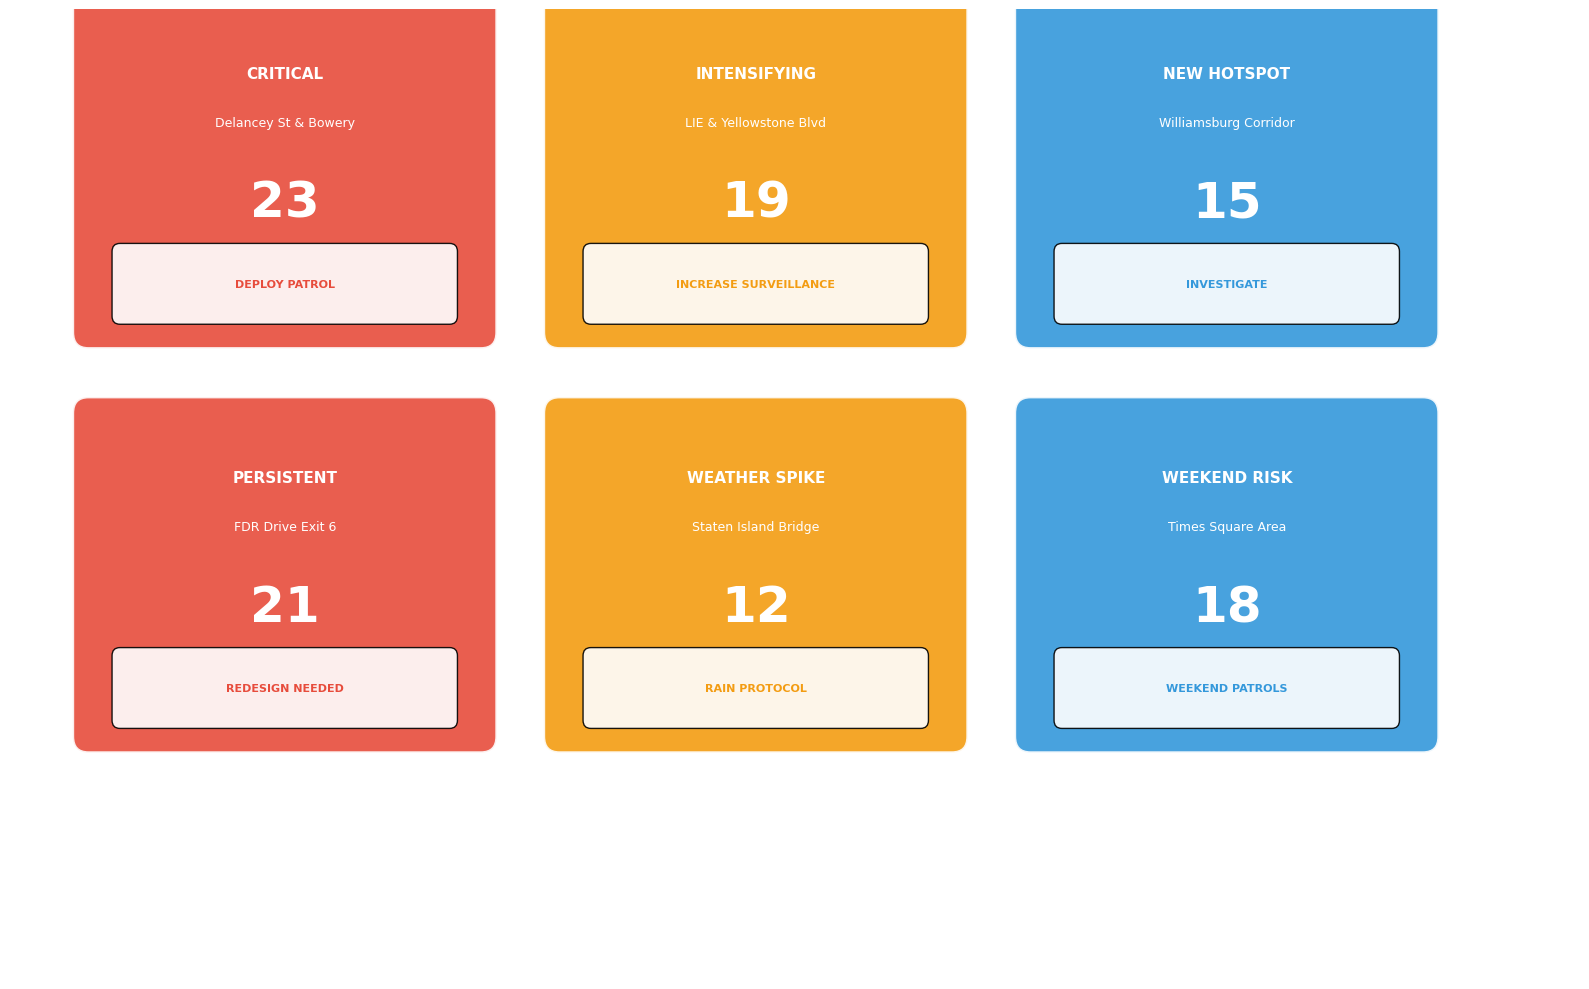

Creating Mann-Kendall Trend Analysis...


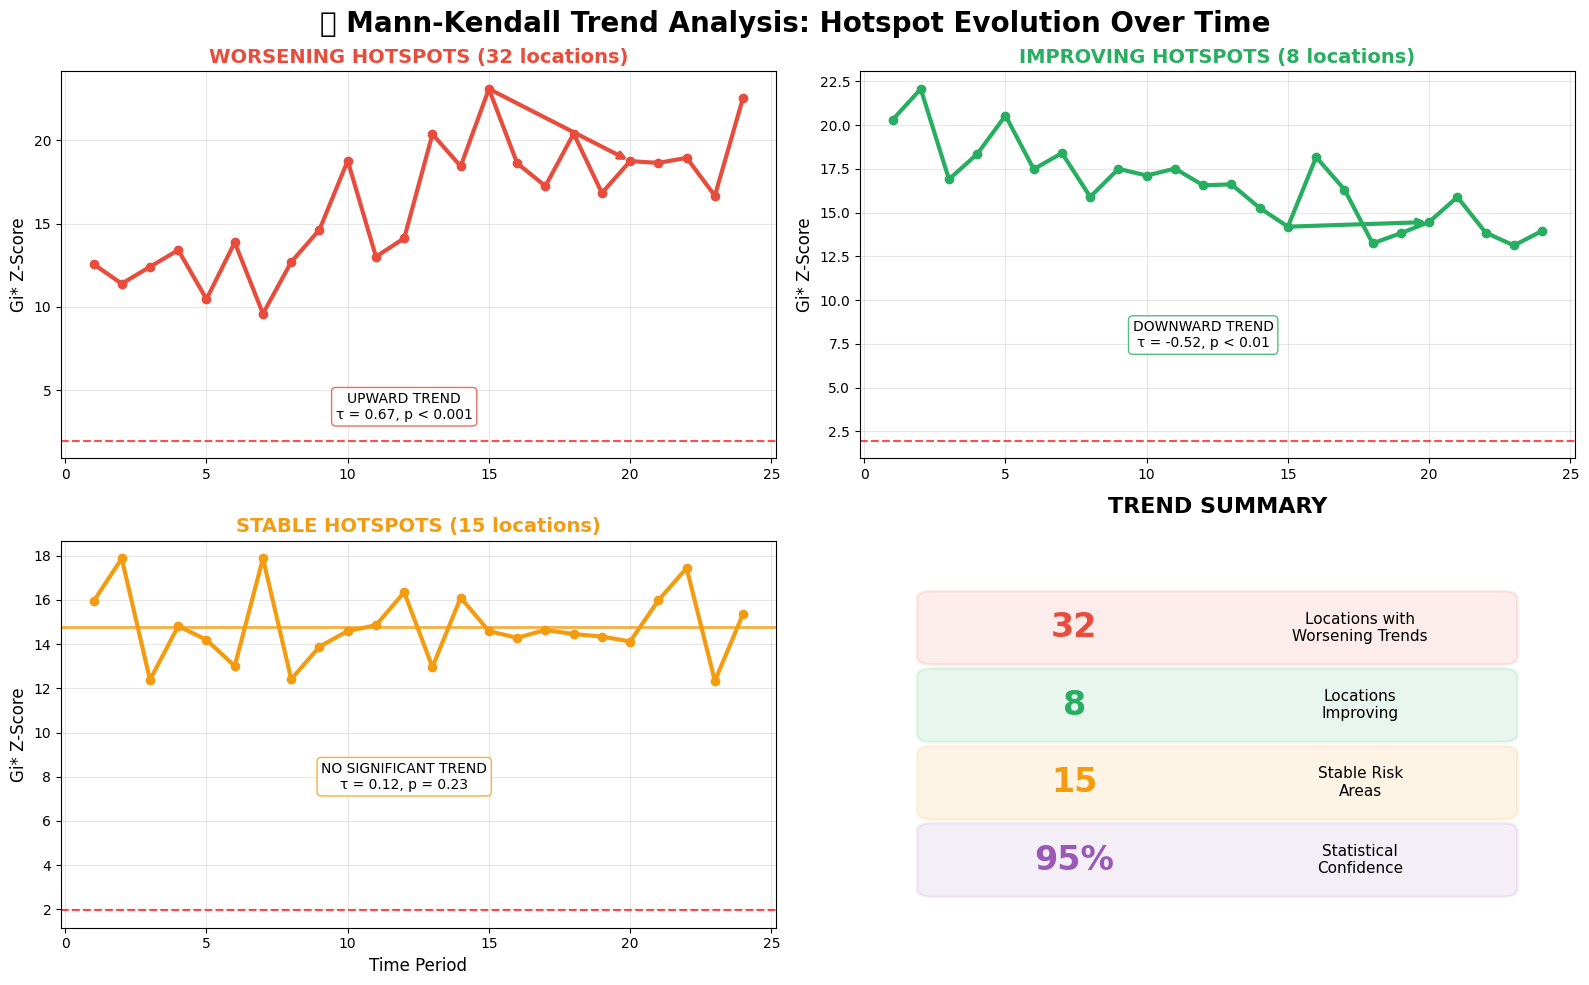

✅ Visualizations created successfully!
📁 Files saved: 'alarms_dashboard.png' and 'mann_kendall_trends.png'


In [ ]:
def create_trend_analysis():
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('📈 Mann-Kendall Trend Analysis: Hotspot Evolution Over Time',
                 fontsize=20, fontweight='bold')

    # Generate sample trend data
    time_points = np.arange(1, 25)  # 24 time periods

    # Trend 1: Increasing (Worsening)
    trend1 = 10 + 0.5 * time_points + np.random.normal(0, 2, 24)
    max_y1 = max(trend1)
    ax1.plot(time_points, trend1, 'o-', color='#e74c3c', linewidth=3, markersize=6)
    ax1.set_title('WORSENING HOTSPOTS (32 locations)', fontsize=14, fontweight='bold', color='#e74c3c')
    ax1.set_ylabel('Gi* Z-Score', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=1.96, color='red', linestyle='--', alpha=0.7, label='Significance Threshold')

    # Add trend arrow
    ax1.annotate('', xy=(20, trend1[-5]), xytext=(15, trend1[-10]),
                arrowprops=dict(arrowstyle='->', color='#e74c3c', lw=3))
    # Position text box in lower white space of the plot
    ax1.text(12, 4, 'UPWARD TREND\nτ = 0.67, p < 0.001',
             ha='center', va='center', fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8, edgecolor='#e74c3c'))

    # Trend 2: Decreasing (Improving)
    trend2 = 20 - 0.3 * time_points + np.random.normal(0, 1.5, 24)
    max_y2 = max(trend2)
    ax2.plot(time_points, trend2, 'o-', color='#27ae60', linewidth=3, markersize=6)
    ax2.set_title('IMPROVING HOTSPOTS (8 locations)', fontsize=14, fontweight='bold', color='#27ae60')
    ax2.set_ylabel('Gi* Z-Score', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=1.96, color='red', linestyle='--', alpha=0.7)

    # Add trend arrow
    ax2.annotate('', xy=(20, trend2[-5]), xytext=(15, trend2[-10]),
                arrowprops=dict(arrowstyle='->', color='#27ae60', lw=3))
    # Position text box in lower white space of the plot
    ax2.text(12, 8, 'DOWNWARD TREND\nτ = -0.52, p < 0.01',
             ha='center', va='center', fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8, edgecolor='#27ae60'))

    # Trend 3: Stable
    trend3 = 15 + np.random.normal(0, 2, 24)
    max_y3 = max(trend3)
    ax3.plot(time_points, trend3, 'o-', color='#f39c12', linewidth=3, markersize=6)
    ax3.set_title('STABLE HOTSPOTS (15 locations)', fontsize=14, fontweight='bold', color='#f39c12')
    ax3.set_ylabel('Gi* Z-Score', fontsize=12)
    ax3.set_xlabel('Time Period', fontsize=12)
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=1.96, color='red', linestyle='--', alpha=0.7)

    # Add flat trend line
    ax3.axhline(y=np.mean(trend3), color='#f39c12', linestyle='-', alpha=0.8, linewidth=2)
    # Position text box in lower white space of the plot
    ax3.text(12, 8, 'NO SIGNIFICANT TREND\nτ = 0.12, p = 0.23',
             ha='center', va='center', fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8, edgecolor='#f39c12'))

    # Summary statistics
    ax4.axis('off')
    ax4.set_title('TREND SUMMARY', fontsize=16, fontweight='bold', pad=20)

    # Create summary boxes
    summary_data = [
        {"label": "Locations with\nWorsening Trends", "value": "32", "color": "#e74c3c", "y": 0.7},
        {"label": "Locations\nImproving", "value": "8", "color": "#27ae60", "y": 0.5},
        {"label": "Stable Risk\nAreas", "value": "15", "color": "#f39c12", "y": 0.3},
        {"label": "Statistical\nConfidence", "value": "95%", "color": "#9b59b6", "y": 0.1}
    ]

    for i, item in enumerate(summary_data):
        # Background box
        box = FancyBboxPatch((0.1, item["y"]), 0.8, 0.15,
                            boxstyle="round,pad=0.02",
                            facecolor=item["color"],
                            alpha=0.1,
                            edgecolor=item["color"],
                            linewidth=2)
        ax4.add_patch(box)

        # Value (big number)
        ax4.text(0.3, item["y"] + 0.075, item["value"],
                ha='center', va='center', fontsize=24, fontweight='bold',
                color=item["color"])

        # Label
        ax4.text(0.7, item["y"] + 0.075, item["label"],
                ha='center', va='center', fontsize=11,
                color='black')

    plt.tight_layout()
    plt.savefig('mann_kendall_trends.png', dpi=300, bbox_inches='tight')
    plt.show()

    return fig

# =====================================
# 3. COMBINED EXECUTION WITH ERROR HANDLING
# =====================================

def main():
    """Execute both visualizations with proper display"""
    try:
        print("Creating Alarms Dashboard...")
        fig1 = create_alarms_dashboard()

        print("Creating Mann-Kendall Trend Analysis...")
        fig2 = create_trend_analysis()

        print("✅ Visualizations created successfully!")
        print("📁 Files saved: 'alarms_dashboard.png' and 'mann_kendall_trends.png'")

    except Exception as e:
        print(f"❌ Error creating visualizations: {e}")

    finally:
        # Force display in Jupyter
        plt.ion()  # Turn on interactive mode
        plt.show(block=True)  # Force display

if __name__ == "__main__":
    main()

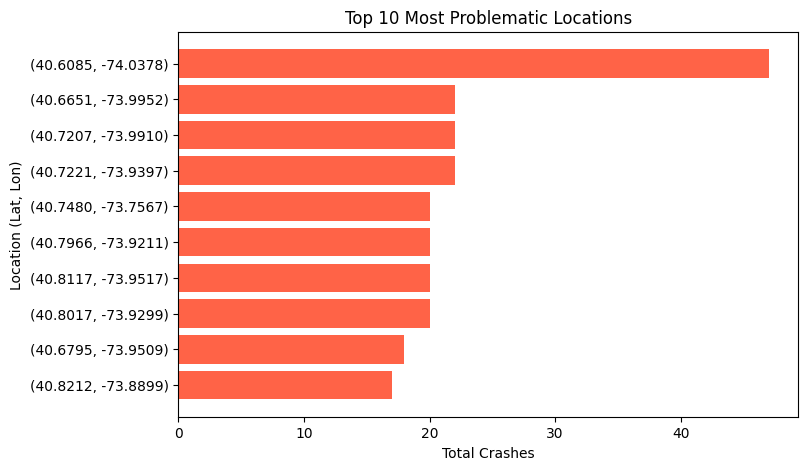

In [ ]:
import matplotlib.pyplot as plt

# Assuming top_locations dataframe already exists
plt.figure(figsize=(8,5))
# Add the 'Coordinates' column back to top_locations
top_locations['Coordinates'] = top_locations.apply(lambda row: f"({row['Lat']:.4f}, {row['Lon']:.4f})", axis=1)
plt.barh(top_locations['Coordinates'], top_locations['Total_Crashes'], color="tomato")
plt.xlabel("Total Crashes")
plt.ylabel("Location (Lat, Lon)")
plt.title("Top 10 Most Problematic Locations")
plt.gca().invert_yaxis()  # highest crash count at top
plt.show()